# **8-1-1**

In [ ]:
# 1. Import thư viện cần thiết
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

Mounted at /content/drive


In [ ]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('/content/drive/MyDrive/StockData/TSLA.csv')
df1=df.reset_index()['Close']

In [ ]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [ ]:
# 4. Chia train test
train_size = int(0.8 * len(df1))
test_size = int(0.1 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [ ]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [ ]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [ ]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [ ]:
# 8. Define LSTM Model

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [ ]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
36/36 [==============================] - 14s 199ms/step - loss: 0.0029 - val_loss: 0.0051
Epoch 2/100
36/36 [==============================] - 8s 224ms/step - loss: 3.4177e-04 - val_loss: 0.0099
Epoch 3/100
36/36 [==============================] - 6s 169ms/step - loss: 3.3020e-04 - val_loss: 0.0077
Epoch 4/100
36/36 [==============================] - 7s 188ms/step - loss: 3.3618e-04 - val_loss: 0.0059
Epoch 5/100
36/36 [==============================] - 10s 290ms/step - loss: 2.4230e-04 - val_loss: 0.0045
Epoch 6/100
36/36 [==============================] - 8s 217ms/step - loss: 2.8591e-04 - val_loss: 0.0061
Epoch 7/100
36/36 [==============================] - 7s 194ms/step - loss: 2.1300e-04 - val_loss: 0.0035
Epoch 8/100
36/36 [==============================] - 7s 201ms/step - loss: 3.2831e-04 - val_loss: 0.0123
Epoch 9/100
36/36 [==============================] - 7s 202ms/step - loss: 2.1600e-04 - val_loss: 0.0044
Epoch 10/100
36/36 [==============================] - 11s

In [ ]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

7/7 [==============================] - 0s 49ms/step


In [ ]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [ ]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
# MAE
MAE_val = np.mean(np.abs(y_pred_val - yval))
MAE_test = np.mean(np.abs(y_pred - ytest))
# MAPE
MAPE_val = np.mean(np.abs((yval - y_pred_val) / yval)) * 100
MAPE_test = np.mean(np.abs((ytest - y_pred) / ytest)) * 100
print('Testing MAE:', MAE_test)
print('Testing RMSE:', test_rmse)
print('Testing MAPE:', MAPE_test)
print('---------------------------')

print('Validation MAE:', MAE_val)
print('Validation RMSE:', valid_rmse)
print('Validation MAPE:', MAPE_val)

Validation RMSE: 225.6294198321191
Testing RMSE: 287.2249736701851


In [ ]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=240
i=0
while(i<30):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


0 day input [0.30317052 0.29778431 0.26338597 0.27222426 0.29452809 0.29785775
 0.26093769 0.27450116 0.26642184 0.27308116 0.28950912 0.2872567
 0.29795569 0.2987881  0.2959481  0.31820296 0.31156812 0.30762639
 0.32292814 0.34821888 0.34856164 0.34988371 0.38866446 0.43182764
 0.40430897 0.42036969 0.4404211  0.45721631 0.46140286 0.47310564
 0.47812462 0.48909291 0.50385604 0.47832048 0.47281185 0.50858122
 0.52079814 0.49092912 0.50627984 0.47949565 0.48804015 0.49100257
 0.478296   0.50461501 0.49991431 0.49271637 0.46365528 0.48052393
 0.47077978 0.45584527 0.44186559 0.41963521 0.42090831 0.42345452
 0.44495042 0.43807076 0.44708043 0.43728731 0.44492594 0.48000979
 0.46426735 0.46688701 0.46245562 0.46588322 0.45946872 0.47095116
 0.47437875 0.5041988  0.47313013 0.46776839 0.45048354 0.44935733
 0.44801077 0.45359285 0.4382911  0.45141388 0.44921043 0.45420492
 0.44752112 0.43841351 0.39532379 0.40044069 0.39424654 0.38964378
 0.37270168 0.3884686  0.39855551 0.39248378 0.3887

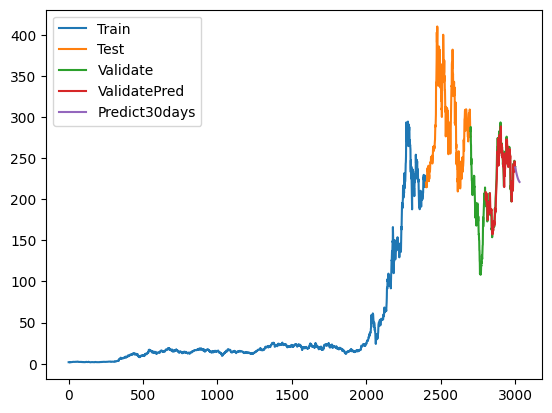

In [ ]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
#plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Validate','ValidatePred','Predict30days'])
plt.show()

# **7-2-1**

In [ ]:
# 1. Import thư viện cần thiết
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('/content/drive/MyDrive/StockData/TSLA.csv')
df1=df.reset_index()['Close']

In [ ]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [ ]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [ ]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [ ]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [ ]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [ ]:
# 8. Define LSTM Model

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [ ]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
32/32 [==============================] - 14s 257ms/step - loss: 2.4148e-04 - val_loss: 0.0166
Epoch 2/100
32/32 [==============================] - 5s 172ms/step - loss: 4.4241e-05 - val_loss: 0.0138
Epoch 3/100
32/32 [==============================] - 8s 247ms/step - loss: 4.1760e-05 - val_loss: 0.0122
Epoch 4/100
32/32 [==============================] - 8s 263ms/step - loss: 3.5155e-05 - val_loss: 0.0144
Epoch 5/100
32/32 [==============================] - 8s 248ms/step - loss: 3.1240e-05 - val_loss: 0.0130
Epoch 6/100
32/32 [==============================] - 5s 171ms/step - loss: 2.9722e-05 - val_loss: 0.0164
Epoch 7/100
32/32 [==============================] - 7s 221ms/step - loss: 2.6359e-05 - val_loss: 0.0147
Epoch 8/100
32/32 [==============================] - 6s 193ms/step - loss: 2.5050e-05 - val_loss: 0.0068
Epoch 9/100
32/32 [==============================] - 6s 173ms/step - loss: 2.1577e-05 - val_loss: 0.0147
Epoch 10/100
32/32 [==============================] - 

In [ ]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

7/7 [==============================] - 0s 35ms/step


In [ ]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [ ]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
# MAE
MAE_val = np.mean(np.abs(y_pred_val - yval))
MAE_test = np.mean(np.abs(y_pred - ytest))
# MAPE
MAPE_val = np.mean(np.abs((yval - y_pred_val) / yval)) * 100
MAPE_test = np.mean(np.abs((ytest - y_pred) / ytest)) * 100
print('Testing MAE:', MAE_test)
print('Testing RMSE:', test_rmse)
print('Testing MAPE:', MAPE_test)
print('---------------------------')

print('Validation MAE:', MAE_val)
print('Validation RMSE:', valid_rmse)
print('Validation MAPE:', MAPE_val)

Testing MAE: 231.65054783934966
Testing RMSE: 236.74129245565516
Testing MAPE: 39004.14926530527
---------------------------
Validation MAE: 202.5685414679139
Validation RMSE: 204.84598483291302
Validation MAPE: 38178.267814981955


In [ ]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=240
i=0
while(i<30):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


0 day input [0.30317052 0.29778431 0.26338597 0.27222426 0.29452809 0.29785775
 0.26093769 0.27450116 0.26642184 0.27308116 0.28950912 0.2872567
 0.29795569 0.2987881  0.2959481  0.31820296 0.31156812 0.30762639
 0.32292814 0.34821888 0.34856164 0.34988371 0.38866446 0.43182764
 0.40430897 0.42036969 0.4404211  0.45721631 0.46140286 0.47310564
 0.47812462 0.48909291 0.50385604 0.47832048 0.47281185 0.50858122
 0.52079814 0.49092912 0.50627984 0.47949565 0.48804015 0.49100257
 0.478296   0.50461501 0.49991431 0.49271637 0.46365528 0.48052393
 0.47077978 0.45584527 0.44186559 0.41963521 0.42090831 0.42345452
 0.44495042 0.43807076 0.44708043 0.43728731 0.44492594 0.48000979
 0.46426735 0.46688701 0.46245562 0.46588322 0.45946872 0.47095116
 0.47437875 0.5041988  0.47313013 0.46776839 0.45048354 0.44935733
 0.44801077 0.45359285 0.4382911  0.45141388 0.44921043 0.45420492
 0.44752112 0.43841351 0.39532379 0.40044069 0.39424654 0.38964378
 0.37270168 0.3884686  0.39855551 0.39248378 0.3887

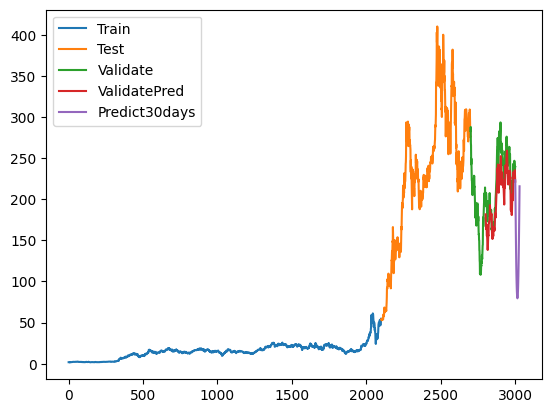

In [ ]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
#plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Validate','ValidatePred','Predict30days'])
plt.show()

# **6-2-2**

In [ ]:
# 1. Import thư viện cần thiết
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [ ]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('/content/drive/MyDrive/StockData/TSLA.csv')
df1=df.reset_index()['Close']

In [ ]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [ ]:
# 4. Chia train test
train_size = int(0.6 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [ ]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [ ]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [ ]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [ ]:
# 8. Define LSTM Model

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [ ]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
27/27 [==============================] - 13s 260ms/step - loss: 2.6639e-04 - val_loss: 0.0425
Epoch 2/100
27/27 [==============================] - 6s 208ms/step - loss: 3.1654e-05 - val_loss: 0.0081
Epoch 3/100
27/27 [==============================] - 5s 174ms/step - loss: 1.1412e-05 - val_loss: 0.0055
Epoch 4/100
27/27 [==============================] - 6s 227ms/step - loss: 9.8531e-06 - val_loss: 0.0044
Epoch 5/100
27/27 [==============================] - 6s 206ms/step - loss: 9.4340e-06 - val_loss: 0.0035
Epoch 6/100
27/27 [==============================] - 5s 175ms/step - loss: 9.6457e-06 - val_loss: 0.0037
Epoch 7/100
27/27 [==============================] - 6s 236ms/step - loss: 8.8370e-06 - val_loss: 0.0037
Epoch 8/100
27/27 [==============================] - 5s 194ms/step - loss: 9.0274e-06 - val_loss: 0.0039
Epoch 9/100
27/27 [==============================] - 5s 174ms/step - loss: 8.8586e-06 - val_loss: 0.0029
Epoch 10/100
27/27 [==============================] - 

In [ ]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

16/16 [==============================] - 1s 58ms/step


In [ ]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [ ]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
# MAE
MAE_val = np.mean(np.abs(y_pred_val - yval))
MAE_test = np.mean(np.abs(y_pred - ytest))
# MAPE
MAPE_val = np.mean(np.abs((yval - y_pred_val) / yval)) * 100
MAPE_test = np.mean(np.abs((ytest - y_pred) / ytest)) * 100
print('Testing MAE:', MAE_test)
print('Testing RMSE:', test_rmse)
print('Testing MAPE:', MAPE_test)
print('---------------------------')

print('Validation MAE:', MAE_val)
print('Validation RMSE:', valid_rmse)
print('Validation MAPE:', MAPE_val)

Testing MAE: 100.46893289775768
Testing RMSE: 123.52552338730348
Testing MAPE: 91654.20853339879
---------------------------
Validation MAE: 200.19838077407633
Validation RMSE: 204.22143496648422
Validation MAPE: 36149.58768366045


In [ ]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=540
i=0
while(i<30):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


0 day input [0.66409597 0.6842698  0.70637777 0.70160362 0.70285225 0.72586608
 0.73867058 0.83266006 0.82742074 0.84326111 0.87523565 0.90539846
 0.98259273 0.95274819 0.9869017  1.         0.99360999 0.94535439
 0.83155833 0.86781736 0.8641939  0.83963765 0.82330763 0.85704493
 0.88500428 0.89102705 0.92422573 0.94038438 0.9013588  0.90703881
 0.87922634 0.92417677 0.93051781 0.88990084 0.88140531 0.82458073
 0.81973314 0.85459665 0.86864977 0.81547313 0.82627005 0.78496756
 0.7785041  0.79277757 0.75272371 0.75735096 0.73071367 0.76219856
 0.81961072 0.86705839 0.88904395 0.88456359 0.8827029  0.86977598
 0.85870976 0.97541927 0.93445954 0.88429428 0.86517322 0.83437385
 0.85981148 0.86492839 0.89905741 0.83811972 0.85285837 0.83726282
 0.80881381 0.80932795 0.76658098 0.75524544 0.7457706  0.76129269
 0.67290978 0.68698739 0.76072959 0.75627372 0.73538989 0.72354021
 0.74978578 0.73676093 0.74870853 0.75688579 0.73448402 0.69812707
 0.71098054 0.74907577 0.74985922 0.71147019 0.695

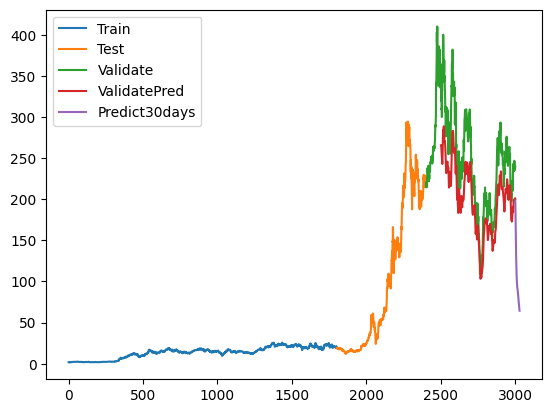

In [ ]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
#plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Validate','ValidatePred','Predict30days'])
plt.show()